In [675]:
import pandas as pd
import numpy as np
from adtk.data import validate_series
from tqdm import tqdm
from adtk.detector import InterQuartileRangeAD
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

In [676]:
df = pd.read_csv("full_data.csv", index_col=None)

/root/nasa/.venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (57) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [677]:
df.rename(columns={str(i): int(i) for i in range(54)}, inplace=True)
df[0] = pd.to_datetime(df[0])
df["is_storm"] = (~df.storm_id.isna()).astype(bool)
try:
    df.drop("Unnamed: 0", axis=1, inplace=True)
except:
    pass

In [678]:
fts = [3]
target = "is_storm"

In [679]:
train_cnt = 10**6
train = df.iloc[: train_cnt][[target] + fts + [0] + ["storm_id"]]
test = df.iloc[train_cnt :][[target] + fts + [0] + ["storm_id"]]

In [680]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [681]:
from adtk.data import validate_series
from vis import plot
from adtk.detector import InterQuartileRangeAD

In [682]:
detector = InterQuartileRangeAD()
train_ano = detector.fit_detect(validate_series(train.loc[:, [0, 3]].set_index(0)))
test_ano = detector.detect(validate_series(test.loc[:, [0, 3]].set_index(0)))

[<AxesSubplot:>]

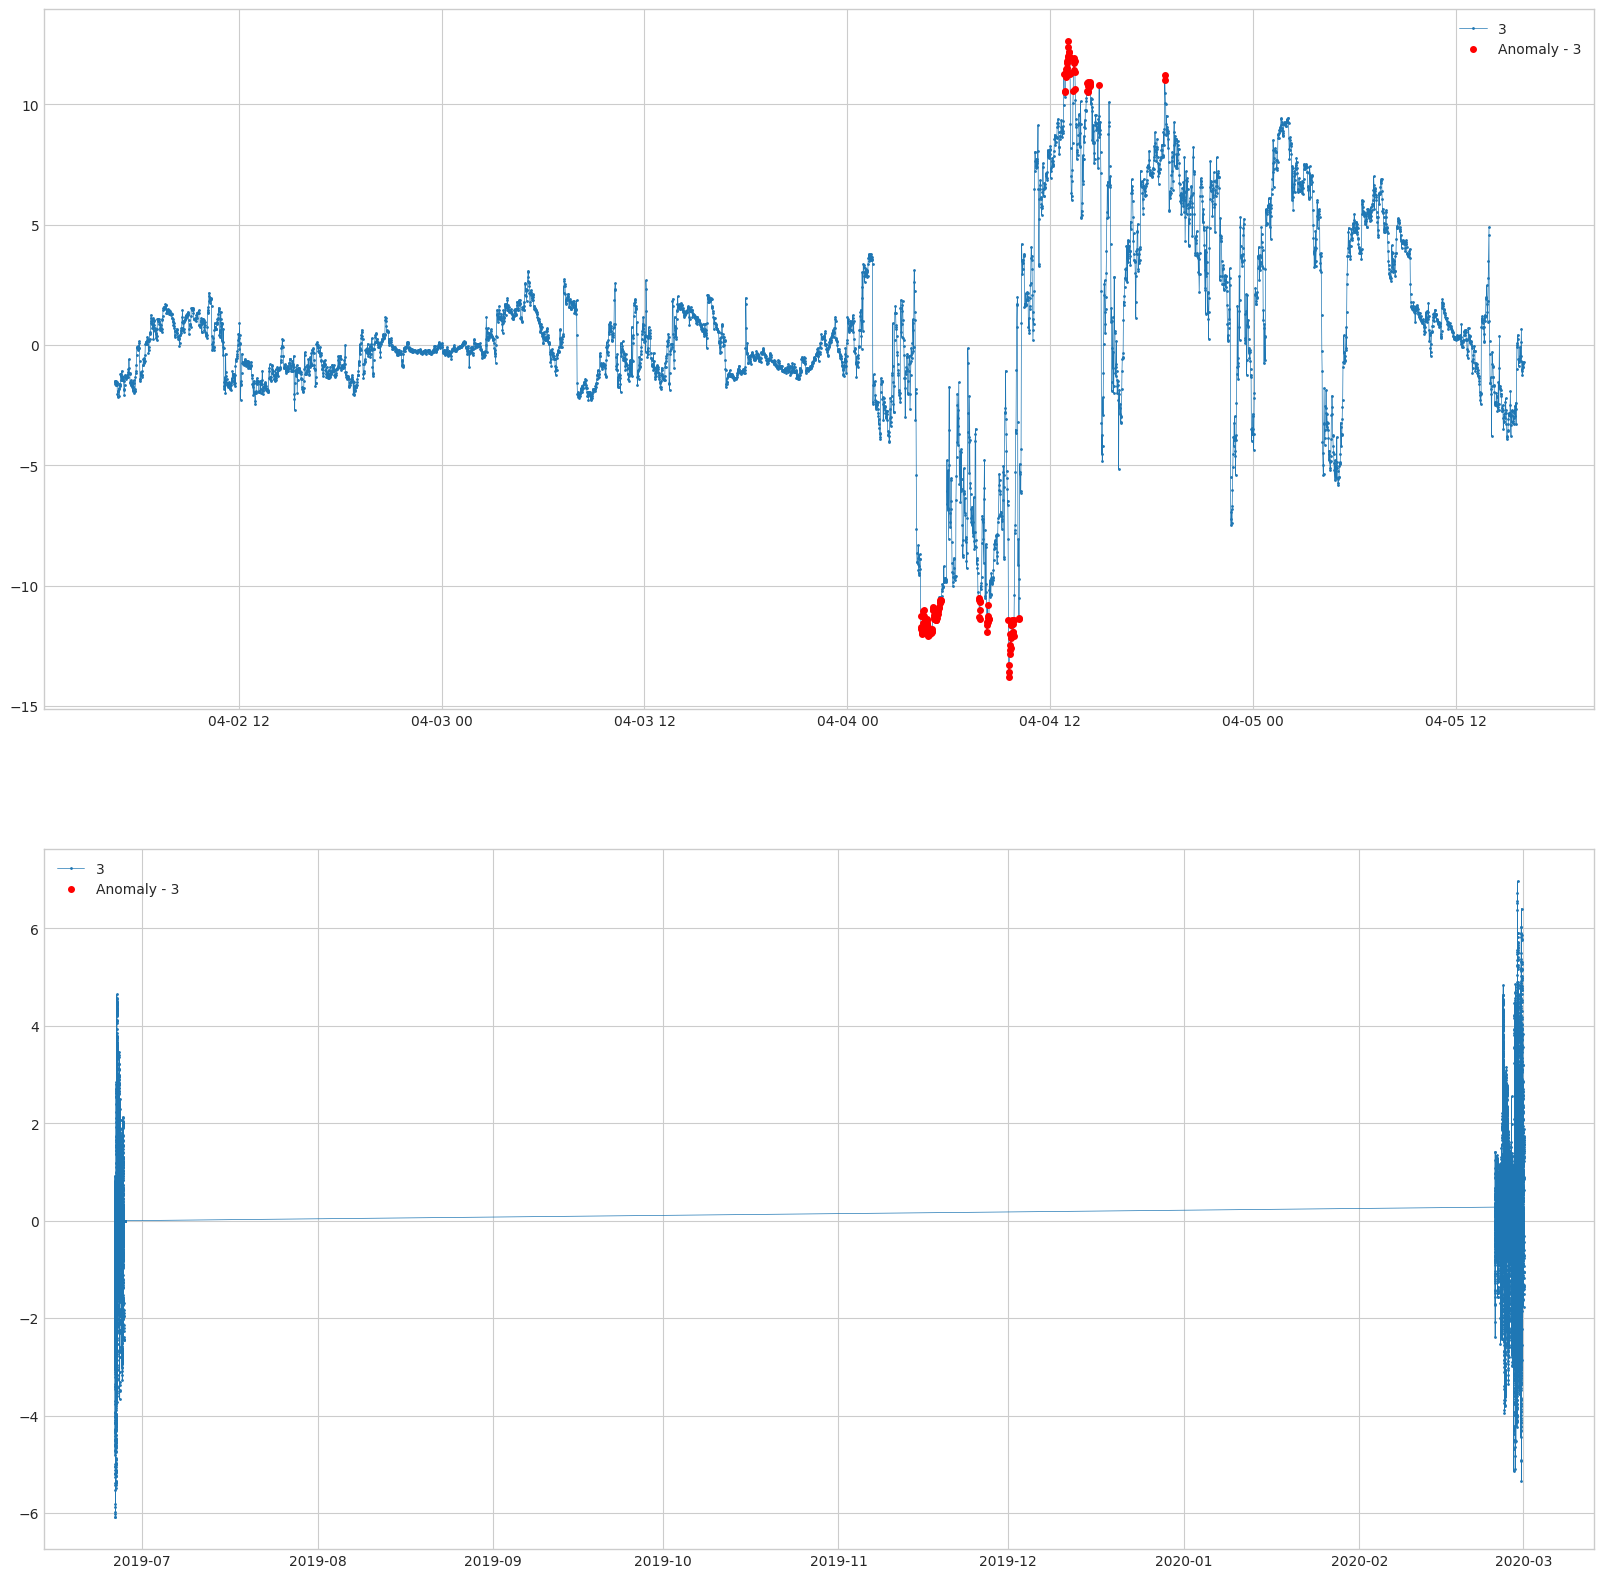

In [696]:
_, axs = plt.subplots(2, 1, figsize=(20, 20))
plot(
    validate_series(train.loc[:, [0, 3]].set_index(0))[415000:420000],
    anomaly=train_ano[415000:420000],
    anomaly_color="red",
    anomaly_tag="marker",
    axes=axs[0],
)
plot(
    validate_series(test.loc[:, [0, 3]].set_index(0))[600000:610000],
    anomaly=test_ano[600000:610000],
    anomaly_color="red",
    anomaly_tag="marker",
    axes=axs[1],
)

In [634]:
train_ano[3] = train_ano.rolling(180).max().fillna(0).astype(bool)[3]
train_ano["is_anomaly"] = train_ano[3]
train_pred = pd.concat(
    [
        train.set_index(0).drop_duplicates(),
        train_ano["is_anomaly"],
    ],
    axis=1,
).fillna(False)
test_ano[3] = test_ano.rolling(180).max().fillna(0).astype(bool)[3]
test_ano["is_anomaly"] = test_ano[3]
test_pred = pd.concat(
    [
        test.set_index(0).drop_duplicates(),
        test_ano["is_anomaly"],
    ],
    axis=1,
).fillna(False)

In [635]:
test_pred.loc[(~test_pred.storm_id.isin([0, False])), :].storm_id.unique().shape

(26,)

In [636]:
test_pred.loc[
    (test_pred.is_anomaly), :
].storm_id.unique().shape

(24,)

In [637]:
test_pred["time_diff_prev_anomaly"] = (
    test_pred.index.to_series().diff().dt.total_seconds() * test_pred["is_anomaly"]
)
y = test_pred.time_diff_prev_anomaly
test_pred["anomaly_minute"] = (
    y * (y.groupby((y != y.shift()).cumsum()).cumcount() + 1) // 60
)
test_pred.fillna(0, inplace=True)

In [638]:
(
    test_pred.loc[(test_pred.is_anomaly) & (test_pred.anomaly_minute < 10), :]
    .storm_id.unique()
    .shape[0]
    - 2
)

22

In [639]:
tmp_df = test_pred[test_pred.is_anomaly]

In [640]:
index = np.concatenate(
    [
        np.array([True]),
        (tmp_df.index[1:] - tmp_df.index[:-1]).values != np.timedelta64(60000000000),
    ],
    axis=0,
)

In [641]:
tmp_df[index].storm_id.unique().shape

(24,)

In [642]:
pd.Series(tmp_df[index].index.to_series().values).to_csv("fin_timesteps.csv", index=False, header=False)

In [643]:
data = df.loc[df[0].isin(tmp_df[index].index.to_series().values), :]

In [674]:
data

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,k_index_current,k_index_target,storm_id,is_storm
1000179,2018-05-05 13:39:00,10.809700,-7.986500,-10.2237,0.00000,0.000000,0.0000,0.0000,0.0000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,4.000,4.667,2018-05-05 15:00:00+00:00,True
1000568,2018-05-05 20:08:00,0.379537,0.141570,-10.9755,0.00000,0.000000,0.0000,0.0000,0.0000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,4.333,5.667,2018-05-05 15:00:00+00:00,True
1025625,2018-05-23 05:45:00,-2.803640,3.778240,10.7181,0.00000,0.000000,0.0000,0.0000,0.0000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,2.000,3.333,NaN,False
1037821,2018-05-31 17:01:00,0.357576,4.211530,-11.3773,0.00000,0.000000,0.0000,0.0000,0.0000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,3.667,4.333,NaN,False
1062684,2018-06-17 23:24:00,-3.470270,5.496320,-12.8959,0.00000,0.000000,0.0000,0.0000,0.0000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.667,4.000,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3218969,2023-03-23 09:29:00,-2.668870,-0.245313,-10.6533,1.09955,0.231726,20.3258,25.8436,33.5028,3.61797,...,0.0,0.0,0.0,0.0,0.0,0.0,4.667,6.667,2023-03-23 06:00:00+00:00,True
3244763,2023-04-10 07:23:00,-5.169890,-4.738740,10.9643,16.02230,0.231726,22.2624,21.7649,36.6813,30.27080,...,0.0,0.0,0.0,0.0,0.0,0.0,3.333,3.000,NaN,False
3256640,2023-04-18 13:20:00,-1.824460,4.405530,12.2746,4.34110,0.231726,11.1115,11.1469,26.5529,14.01040,...,0.0,0.0,0.0,0.0,0.0,0.0,3.667,4.667,NaN,False
3263744,2023-04-23 11:44:00,-0.781280,4.549100,-10.6857,19.74550,0.231726,28.3237,26.6635,39.7454,34.31920,...,0.0,0.0,0.0,0.0,0.0,0.0,3.333,4.667,2023-04-23 12:00:00+00:00,True


In [666]:
fts = [i for i in range(1, 54)]+["k_index_current"]

In [673]:
24/26

0.9230769230769231

In [667]:
train_cnt = 100
train = data.iloc[: train_cnt][fts+["is_storm"]]
test = data.iloc[train_cnt :][fts+["is_storm"]]

In [668]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

model = LogisticRegression(class_weight="balanced")
model.fit(train[fts], train["is_storm"])

/root/nasa/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(class_weight='balanced')

/root/nasa/.venv/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


<AxesSubplot:>

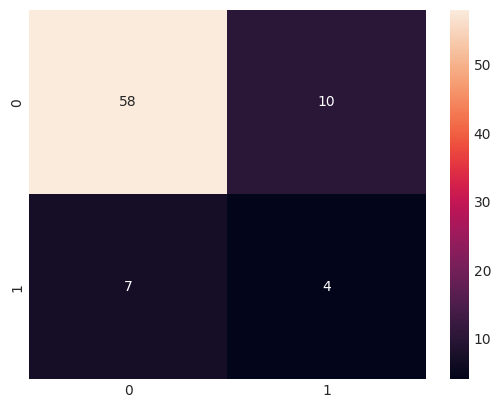

In [670]:
y_pred = model.predict(test[fts])
y_true = test["is_storm"]

sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d")

/root/nasa/.venv/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


<AxesSubplot:>

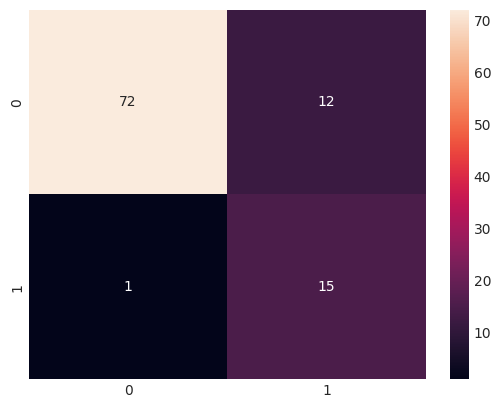

In [671]:
y_pred = model.predict(train[fts])
y_true = train["is_storm"]

sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d")

In [672]:
15/16, 15/27

(0.9375, 0.5555555555555556)